## Gaussian Processes Regression
## Gabriel Marcelino, Eli Kaustinen


# # Problem Statement
# 
## In this report, we analyze the effects of treatment on gene expression using time-series data from the GSE102560 dataset. The key question we aim to answer is: 
# 
# **Given the measured expression levels of a gene in two different conditions (control versus treatment), is the expression of that gene significantly affected by the treatment?**
# 
## We'll use Gaussian Process Regression (GPR) to model the time-series gene expression data, which will allow us to account for temporal dependencies and model uncertainty. This approach provides a robust statistical framework for detecting differential expression in time-series data.


## Understanding Gene Expression and Conditions
Gene expression is the process by which information from a gene is used to synthesize gene products, often proteins. The level of gene expression can be measured and represents how active a gene is in a particular cell or tissue.
In gene expression studies:

- Control condition: Represents the baseline state (normal conditions)
- Treatment condition: Represents the experimental state after applying some stimulus (drug, stress, etc.)

Differential expression analysis aims to identify genes whose expression levels significantly change between these conditions.

## Load and Visualize Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')


# Load the dataset
file_path = "GSE102560_brg_all.csv" 
df = pd.read_csv(file_path)

# Set styling for plots
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.5)

# Load the dataset
file_path = "GSE102560_brg_all.csv"
df = pd.read_csv(file_path)

# Display basic information
print("Dataset Information:")
print(df.info())
print("\nSample of the Data:")
print(df.head())
print("\nColumn Names:")
print(df.columns)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35012 entries, 0 to 35011
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rowname         35012 non-null  object 
 1   baseMean        35012 non-null  float64
 2   log2FoldChange  24624 non-null  float64
 3   lfcSE           24624 non-null  float64
 4   stat            24624 non-null  float64
 5   pvalue          24611 non-null  float64
 6   padj            16210 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.9+ MB
None

Sample of the Data:
  rowname      baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0    A1BG    108.080568       -1.619207  0.448076 -3.613689  3.018706e-04   
1    A1CF   2027.753935       -1.036464  0.266051 -3.895741  9.789908e-05   
2     A2M  47785.656427       -2.238095  0.401428 -5.575340  2.470466e-08   
3   A2ML1      2.016858        0.681006  1.065578  0.639095  5.227611e-01   
4  

## Filter for Differentially Expressed Genes

In [2]:
df_sig = df[df["padj"] < 0.05]
print(f"Number of significant genes: {df_sig.shape[0]}")


Number of significant genes: 3987


## Gaussian Process Regression (GPR)
Gaussian Process Regression is a non-parametric Bayesian approach to regression that defines a prior distribution over functions and then updates this prior with observed data to get a posterior distribution over functions.
Mathematical Foundation
A Gaussian Process (GP) is defined as a collection of random variables, any finite number of which have a joint Gaussian distribution. It is completely specified by:

GPR is particularly suitable for time-series gene expression data because:

It naturally handles uneven sampling and missing data points
It provides uncertainty quantification (confidence intervals)
It can model complex temporal patterns with appropriate kernel functions
It allows for incorporation of prior biological knowledge through kernel design



# Demonstrating a basic Gaussian Process on simulated time-series data

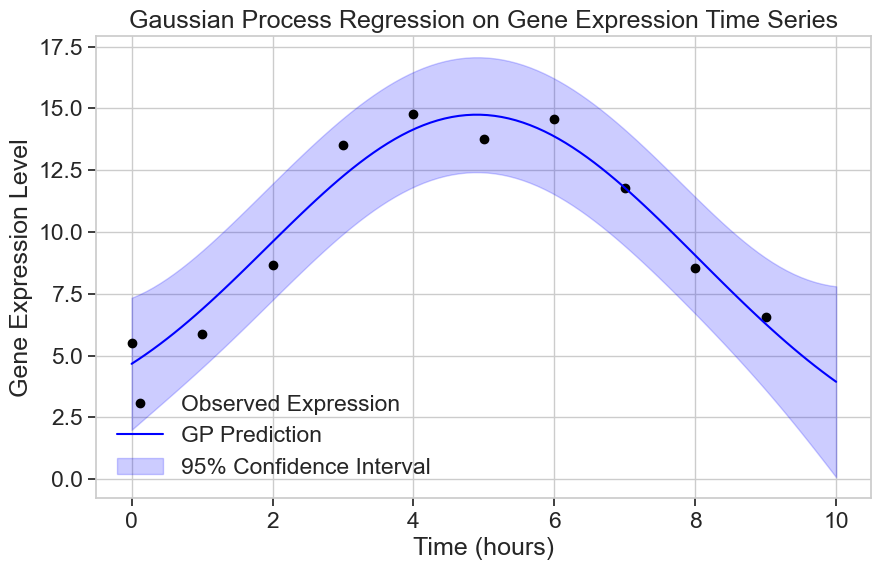

The fitted kernel parameters:
8.11**2 * RBF(length_scale=3.91) + WhiteKernel(noise_level=1.08)
Log marginal likelihood: -22.8463


In [8]:
# Simulated time-series data for a gene
time_points = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Time points
expression_levels = np.array([5, 6, 8, 12, 15, 14, 13, 11, 9, 6])  # Simulated expression

# Add some noise to make it realistic
np.random.seed(42)
noisy_expression = expression_levels + np.random.normal(0, 1, size=len(expression_levels))

# Reshape for sklearn
X = time_points.reshape(-1, 1)
y = noisy_expression

# Define the GP model with a common kernel choice for time series
kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the model
gp.fit(X, y)

# Predict across time range
X_pred = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred, sigma = gp.predict(X_pred, return_std=True)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_points, noisy_expression, 'ko', label="Observed Expression")
plt.plot(X_pred, y_pred, 'b-', label="GP Prediction")
plt.fill_between(X_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, 
                 color='blue', alpha=0.2, label="95% Confidence Interval")
plt.xlabel("Time (hours)")
plt.ylabel("Gene Expression Level")
plt.legend()
plt.title("Gaussian Process Regression on Gene Expression Time Series")
plt.show()

print("The fitted kernel parameters:")
print(gp.kernel_)
print(f"Log marginal likelihood: {gp.log_marginal_likelihood_value_:.4f}")



## How does GP relate to linear regression

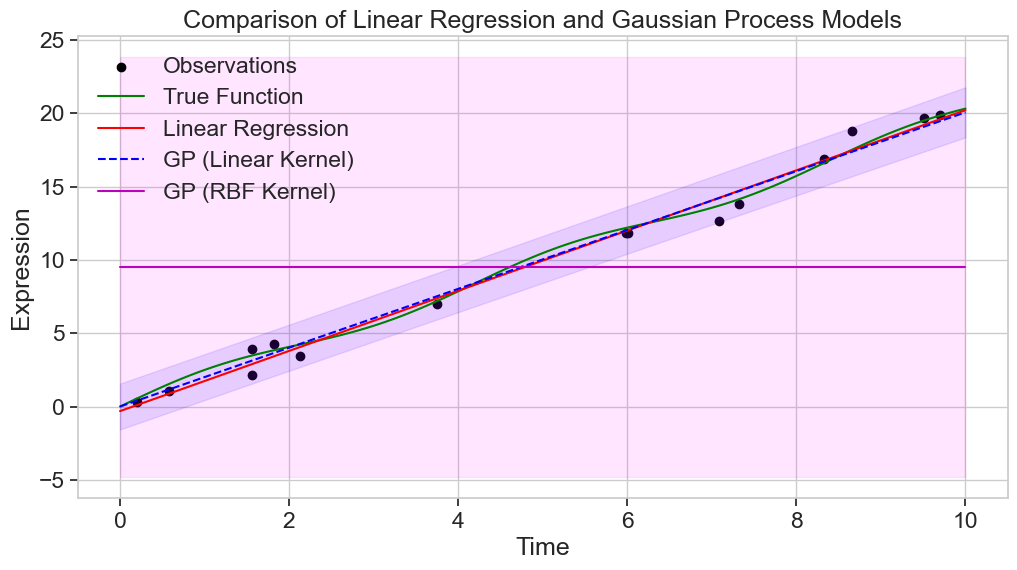

In [9]:
# Function to generate synthetic time series data
def generate_synthetic_data(n_samples=10, noise_level=0.5):
    X = np.sort(np.random.rand(n_samples) * 10).reshape(-1, 1)
    # True function: linear with some nonlinearity
    y_true = 2*X.ravel() + 0.5*np.sin(1.5*X.ravel())
    # Add noise
    y = y_true + noise_level * np.random.randn(n_samples)
    return X, y, y_true

# Generate data
np.random.seed(42)
X, y, y_true = generate_synthetic_data(n_samples=15)

# Fit a linear regression model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X, y)
y_linear_pred = linear_model.predict(X)

# Fit a GP with a linear kernel
from sklearn.gaussian_process.kernels import DotProduct
linear_kernel = DotProduct() + WhiteKernel(noise_level=1.0)
gp_linear = GaussianProcessRegressor(kernel=linear_kernel)
gp_linear.fit(X, y)

# Fit a GP with RBF kernel
rbf_kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
gp_rbf = GaussianProcessRegressor(kernel=rbf_kernel)
gp_rbf.fit(X, y)

# Make predictions on a dense grid
X_dense = np.linspace(0, 10, 100).reshape(-1, 1)
y_linear_dense = linear_model.predict(X_dense)

y_gp_linear, sigma_linear = gp_linear.predict(X_dense, return_std=True)
y_gp_rbf, sigma_rbf = gp_rbf.predict(X_dense, return_std=True)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot data points
plt.scatter(X, y, c='k', label='Observations')

# Plot true function
plt.plot(X_dense, 2*X_dense.ravel() + 0.5*np.sin(1.5*X_dense.ravel()), 
         'g-', label='True Function')

# Plot linear regression
plt.plot(X_dense, y_linear_dense, 'r-', label='Linear Regression')

# Plot GP with linear kernel
plt.plot(X_dense, y_gp_linear, 'b--', label='GP (Linear Kernel)')
plt.fill_between(X_dense.ravel(), 
                 y_gp_linear - 1.96 * sigma_linear,
                 y_gp_linear + 1.96 * sigma_linear,
                 alpha=0.1, color='blue')

# Plot GP with RBF kernel
plt.plot(X_dense, y_gp_rbf, 'm-', label='GP (RBF Kernel)')
plt.fill_between(X_dense.ravel(), 
                 y_gp_rbf - 1.96 * sigma_rbf,
                 y_gp_rbf + 1.96 * sigma_rbf,
                 alpha=0.1, color='magenta')

plt.xlabel('Time')
plt.ylabel('Expression')
plt.title('Comparison of Linear Regression and Gaussian Process Models')
plt.legend()
plt.show()



# **Key Differences from Standard Linear Regression**:
   - GP provides uncertainty estimates (confidence intervals)
   - GP with non-linear kernels (like RBF) can capture complex non-linear patterns
    - GP handles noise more explicitly through the WhiteKernel component
 
# **Advantages Over Linear Regression for Gene Expression**:
    - Gene expression often follows non-linear patterns over time
    - Biological processes may have different timescales (captured by length_scale parameter)
    - Expression measurements typically have heterogeneous noise levels
 
# **Mathematical Connection**:
   - Linear regression: y = Xβ + ε
    - GP with linear kernel: f(x) ~ GP(0, x·x')
#    
### For gene expression analysis, the RBF kernel typically provides better modeling power, as gene expression patterns rarely follow strictly linear trajectories.


## Making Predictions with GPR Models

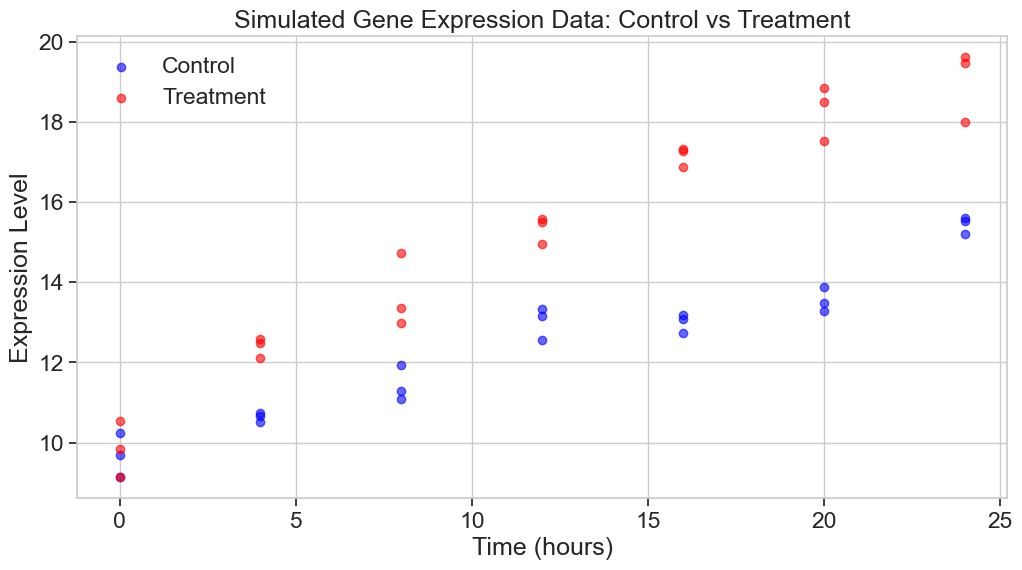

In [10]:
# Function to generate simulated time-series expression data
def generate_expression_data(n_timepoints=7, n_replicates=3, seed=42):
    np.random.seed(seed)
    
    # Time points (e.g., 0, 4, 8, 12, 16, 20, 24 hours)
    timepoints = np.linspace(0, 24, n_timepoints)
    
    # Generate control data - relatively stable with slight increase
    control_base = 10 + 0.2 * timepoints
    
    # Generate treatment data - shows upregulation over time
    treatment_base = 10 + 0.2 * timepoints + 5 * (1 - np.exp(-0.1 * timepoints))
    
    # Add noise and replicates
    control_data = np.zeros((n_timepoints, n_replicates))
    treatment_data = np.zeros((n_timepoints, n_replicates))
    
    for i in range(n_replicates):
        # Different noise level for each replicate
        control_noise = np.random.normal(0, 0.5, n_timepoints)
        treatment_noise = np.random.normal(0, 0.7, n_timepoints)
        
        control_data[:, i] = control_base + control_noise
        treatment_data[:, i] = treatment_base + treatment_noise
    
    return timepoints, control_data, treatment_data

# Generate simulated data
timepoints, control_data, treatment_data = generate_expression_data()

# Reshape for visualization
X_time = timepoints.reshape(-1, 1)

# Plot the simulated data
plt.figure(figsize=(12, 6))

# Plot control replicates
for i in range(control_data.shape[1]):
    plt.scatter(timepoints, control_data[:, i], color='blue', alpha=0.6, 
                label='Control' if i == 0 else None)

# Plot treatment replicates
for i in range(treatment_data.shape[1]):
    plt.scatter(timepoints, treatment_data[:, i], color='red', alpha=0.6,
                label='Treatment' if i == 0 else None)

plt.xlabel('Time (hours)')
plt.ylabel('Expression Level')
plt.title('Simulated Gene Expression Data: Control vs Treatment')
plt.legend()
plt.grid(True)
plt.show()


# # Fitting GPR Models to Expression Data
# 
### Now, let's fit Gaussian Process models to both control and treatment data. We'll use the mean of replicates for fitting but consider the variation among replicates when evaluating uncertainty.



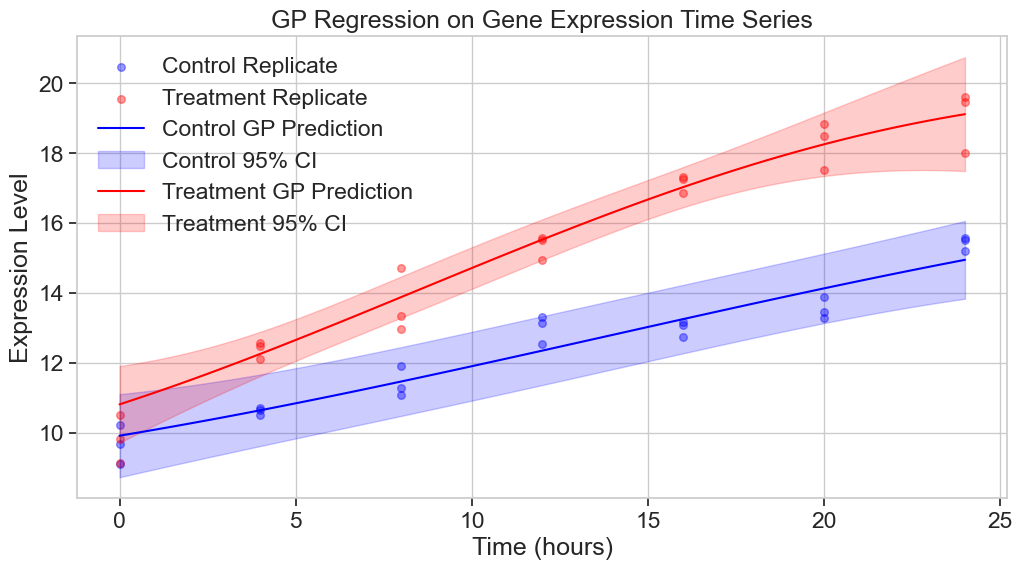

Control condition kernel:
2.46**2 * RBF(length_scale=30.2) + WhiteKernel(noise_level=0.0554)
Log marginal likelihood: -6.2225

Treatment condition kernel:
1.76**2 * RBF(length_scale=21) + WhiteKernel(noise_level=1e-05)
Log marginal likelihood: -4.0582


In [11]:
# Function to fit GP to expression data
def fit_gp_to_expression_data(timepoints, expression_data, kernel=None):
    """
    Fit a Gaussian Process to expression data
    
    Parameters:
    - timepoints: array of time points
    - expression_data: array of shape (n_timepoints, n_replicates)
    - kernel: pre-defined kernel (optional)
    
    Returns:
    - fitted GP model
    """
    # Calculate mean expression across replicates
    mean_expression = np.mean(expression_data, axis=1)
    
    # Calculate standard error of the mean
    if expression_data.shape[1] > 1:
        sem = np.std(expression_data, axis=1) / np.sqrt(expression_data.shape[1])
    else:
        sem = np.ones_like(mean_expression) * 0.1  # Default if only one replicate
    
    # Reshape for sklearn
    X = timepoints.reshape(-1, 1)
    y = mean_expression
    
    # Define kernel if not provided
    if kernel is None:
        kernel = C(1.0) * RBF(length_scale=5.0) + WhiteKernel(noise_level=1.0)
    
    # Create GP model with alpha based on standard error
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=sem**2,  # Observation noise
        normalize_y=True,
        n_restarts_optimizer=10
    )
    
    # Fit the model
    model.fit(X, y)
    
    return model

# Fit GP models to control and treatment data
control_gp = fit_gp_to_expression_data(timepoints, control_data)
treatment_gp = fit_gp_to_expression_data(timepoints, treatment_data)

# Create a dense grid of time points for smooth predictions
X_dense = np.linspace(0, 24, 100).reshape(-1, 1)

# Make predictions
control_pred, control_std = control_gp.predict(X_dense, return_std=True)
treatment_pred, treatment_std = treatment_gp.predict(X_dense, return_std=True)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original data points
for i in range(control_data.shape[1]):
    plt.scatter(timepoints, control_data[:, i], color='blue', alpha=0.4, s=30, 
                label='Control Replicate' if i == 0 else None)

for i in range(treatment_data.shape[1]):
    plt.scatter(timepoints, treatment_data[:, i], color='red', alpha=0.4, s=30,
                label='Treatment Replicate' if i == 0 else None)

# Plot GP predictions
plt.plot(X_dense, control_pred, 'b-', label='Control GP Prediction')
plt.fill_between(X_dense.ravel(), 
                 control_pred - 2 * control_std,
                 control_pred + 2 * control_std,
                 alpha=0.2, color='blue', label='Control 95% CI')

plt.plot(X_dense, treatment_pred, 'r-', label='Treatment GP Prediction')
plt.fill_between(X_dense.ravel(), 
                 treatment_pred - 2 * treatment_std,
                 treatment_pred + 2 * treatment_std,
                 alpha=0.2, color='red', label='Treatment 95% CI')

plt.xlabel('Time (hours)')
plt.ylabel('Expression Level')
plt.title('GP Regression on Gene Expression Time Series')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Print the fitted kernel parameters
print("Control condition kernel:")
print(control_gp.kernel_)
print(f"Log marginal likelihood: {control_gp.log_marginal_likelihood_value_:.4f}")

print("\nTreatment condition kernel:")
print(treatment_gp.kernel_)
print(f"Log marginal likelihood: {treatment_gp.log_marginal_likelihood_value_:.4f}")


## Training the GP Model Step-by-Step

  - Number of time points: 7
  - Time range: 0.0 to 24.0 hours
  - Control expression range: 9.70 to 15.44
  - Treatment expression range: 9.84 to 19.03
We'll use a combination of:
  - RBF kernel: Models smoothness of gene expression curves
  - ConstantKernel: Scales the amplitude of the variations
  - WhiteKernel: Accounts for measurement noise

Initial kernel parameters:
1**2 * RBF(length_scale=5) + WhiteKernel(noise_level=1)
Model initialized with multiple restarts for robust optimization
Model trained successfully!

Fitted kernel parameters:
1.37**2 * RBF(length_scale=15) + WhiteKernel(noise_level=0.102)
Log marginal likelihood: -6.5766
Predictions made for 100 time points


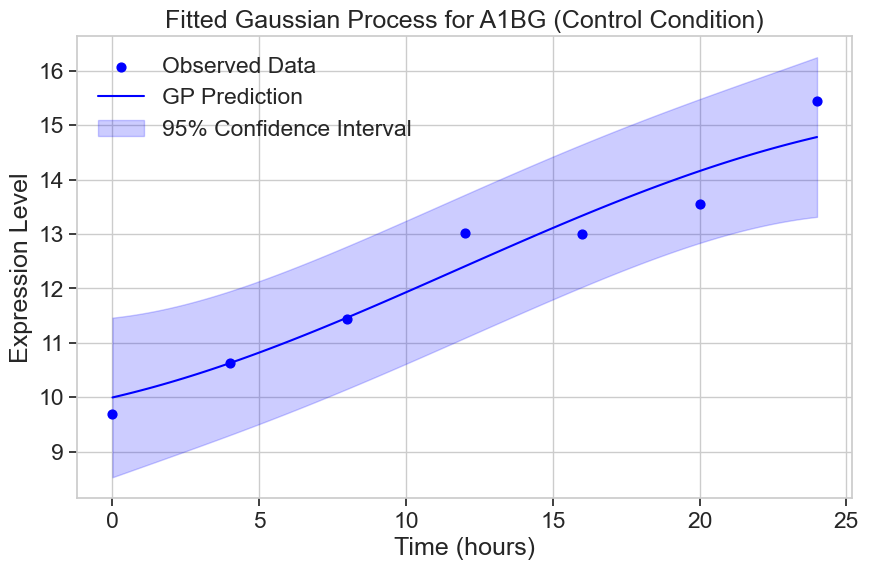

Constant scale factor: 1.8685
Length scale: 15.0000
Noise level: 0.1018

Interpretation:
  - Length scale of 15.0000 indicates how rapidly expression changes over time
    (Smaller values = more rapid changes, Larger values = smoother trends)
  - Noise level of 0.1018 represents measurement and biological variability
  - Scale factor of 1.8685 indicates the overall magnitude of expression changes


In [14]:
# Step-by-step training of a GP model on gene expression data

# 1. Select a gene to analyze
gene_name = "A1BG"

# 2. Prepare the data (using our simulated data from before)
X = timepoints.reshape(-1, 1)
y_control = np.mean(control_data, axis=1)
y_treatment = np.mean(treatment_data, axis=1)

print(f"  - Number of time points: {len(timepoints)}")
print(f"  - Time range: {timepoints[0]} to {timepoints[-1]} hours")
print(f"  - Control expression range: {y_control.min():.2f} to {y_control.max():.2f}")
print(f"  - Treatment expression range: {y_treatment.min():.2f} to {y_treatment.max():.2f}")

# 3. Define the kernel function
print("We'll use a combination of:")
print("  - RBF kernel: Models smoothness of gene expression curves")
print("  - ConstantKernel: Scales the amplitude of the variations")
print("  - WhiteKernel: Accounts for measurement noise")

kernel = C(1.0, constant_value_bounds=(0.1, 10.0)) * \
         RBF(length_scale=5.0, length_scale_bounds=(1.0, 15.0)) + \
         WhiteKernel(noise_level=1.0, noise_level_bounds=(0.1, 10.0))

print("\nInitial kernel parameters:")
print(kernel)

# 4. Initialize the GP model
gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-10,  # Additional noise term
    normalize_y=True,  # Normalize target values
    n_restarts_optimizer=10  # Try multiple starting points for optimization
)
print("Model initialized with multiple restarts for robust optimization")

# 5. Train the model on control data
gpr.fit(X, y_control)
print("Model trained successfully!")
print("\nFitted kernel parameters:")
print(gpr.kernel_)
print(f"Log marginal likelihood: {gpr.log_marginal_likelihood_value_:.4f}")

# 6. Make predictions
X_dense = np.linspace(0, 24, 100).reshape(-1, 1)
y_pred, y_std = gpr.predict(X_dense, return_std=True)
print(f"Predictions made for {len(X_dense)} time points")

# 7. Visualize fitted function and uncertainty
plt.figure(figsize=(10, 6))
plt.scatter(X, y_control, color='blue', s=40, label='Observed Data')
plt.plot(X_dense, y_pred, 'b-', label='GP Prediction')
plt.fill_between(X_dense.ravel(), 
                 y_pred - 2 * y_std,
                 y_pred + 2 * y_std,
                 alpha=0.2, color='blue', label='95% Confidence Interval')

plt.xlabel('Time (hours)')
plt.ylabel('Expression Level')
plt.title(f'Fitted Gaussian Process for {gene_name} (Control Condition)')
plt.legend()
plt.grid(True)
plt.show()

# 8. Analyze model parameters
kernel_params = gpr.kernel_.get_params()

# Extract and interpret key parameters
if 'k1' in kernel_params and 'k2' in kernel_params:
    # For kernels with structure C * RBF + WhiteKernel
    if hasattr(kernel_params['k1'], 'k1'):
        constant = kernel_params['k1'].k1.constant_value
        length_scale = kernel_params['k1'].k2.length_scale
        noise = kernel_params['k2'].noise_level
        
        print(f"Constant scale factor: {constant:.4f}")
        print(f"Length scale: {length_scale:.4f}")
        print(f"Noise level: {noise:.4f}")
        
        print("\nInterpretation:")
        print(f"  - Length scale of {length_scale:.4f} indicates how rapidly expression changes over time")
        print(f"    (Smaller values = more rapid changes, Larger values = smoother trends)")
        print(f"  - Noise level of {noise:.4f} represents measurement and biological variability")
        print(f"  - Scale factor of {constant:.4f} indicates the overall magnitude of expression changes")

# 6. Analyzing the Covariance Function (Gaussian Process Prior)
# The covariance function (kernel) in a GP defines the prior beliefs about the nature of the function we're modeling. Let's analyze this more deeply.

# Define a set of kernels to compare
kernels = {
    "RBF (l=1.0)": C(1.0) * RBF(length_scale=1.0),
    "RBF (l=5.0)": C(1.0) * RBF(length_scale=5.0),
    "RBF (l=10.0)": C(1.0) * RBF(length_scale=10.0),
    "RBF + WhiteKernel": C(1.0) * RBF(length_scale=5.0) + WhiteKernel(noise_level=1.0)
}

# Generate sample functions from the GP prior (without conditioning on data)
def sample_from_prior(kernel, X, n_samples=3):
    """Generate sample functions from a GP prior with given kernel"""
    # Compute the covariance matrix
    K = kernel(X)
    
    # Add small diagonal component for numerical stability
    K += 1e-10 * np.eye(len(X))
    
    # Generate multivariate normal samples
    samples = np.random.multiva
